# MPLS-Kit Demonstration Notebook
This notebook provides a functional example on the capabilities of the MPLS-Kit 

Demonstration NoteBook for MPLS Kit v0.1

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

Copyright: Juan Vanerio (juan.vanerio@univie.ac.at)
Created by Juan Vanerio, 2022

In [1]:
#Load requirements

import networkx as nx
import matplotlib.pyplot as plt
import random
import time
import jsonschema
import json
import math 
from pprint import pprint
from itertools import chain, count

from networkx.algorithms.shortest_paths.weighted import _weight_function, _dijkstra_multisource
from resource import getrusage, RUSAGE_SELF

import sys
sys.path.append('../')
from mpls_fwd_gen import *
from simulation import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

##  Choose the topology
In the next cell you can choose among three options to experiemnt with topologies: generate a random one, load one from an external file or simply define a custom topology in python.

In [2]:
# Topology configuration
topology_option = "random"   # You can free from the following options: random, external, custom.

#random_seed
random_seed = 1

# Get topology
if topology_option == "random":
    mode = "random.log_degree"   # custom, random.log_degree, random.large_degree
    n = 10                     # number of nodes, for random only
    weight_mode = "random"       # random or equal or distance
    gen_method = 1               # method for generating the random topology
    
    G = generate_topology(mode, 
                      n, 
                      weight_mode = "random", 
                      gen_method = 1, 
                      visualize = False, 
                      display_tables = False, 
                      random_seed = random_seed 
                     )

    
elif topology_option == "external":   
    G = topology_from_aalwines_json("example/abilene.json", visualize = True)

    
elif topology_option == "custom":
    G = nx.Graph()
    G.add_edge("R7", "R0", weight=1)
    G.add_edge("R0", "R1", weight=1)
    G.add_edge("R0", "R2", weight=1)
    G.add_edge("R0", "R3", weight=1)
    G.add_edge("R3", "R2", weight=1)
    G.add_edge("R2", "R4", weight=1)
    G.add_edge("R4", "R1", weight=1.5)
    G.add_edge("R1", "R5", weight=1)
    G.add_edge("R4", "R6", weight=1)
    
    
n = G.number_of_nodes() 
visualize = True if n<60 else False     # Use only with small networks
display_tables = False                  # Use only with small networks

Number of edges: 18


## Demo parameters
In the next cell you Set parameter values for all MPLS protocols and features that you want deployed in the network.

In [3]:
# Generator configuration
enable_PHP = False
numeric_labels = False


## LDP
enable_LDP = False


## RSVP
enable_RSVP = True

protection = "facility-node" # options: None, "facility-node"

if topology_option == "custom":
    num_lsps = [("R7","R5"),("R7","R5"),("R0","R6")]  # Explicit tunnels to create.
else:
    num_lsps = 10           # Maximum number of LSPS to compute at random for RSVP only

tunnels_per_pair = 1    # no. of tunnels between same head / endtail with the exact same path


## VPN Services
enable_services = False
num_services = 40
PE_s_per_service = 3
CEs_per_PE = 1

## Generate MPLS forwarding rules

In [4]:
network = generate_fwd_rules(G, 
                             enable_PHP = enable_PHP, 
                             numeric_labels = numeric_labels, 
                             enable_LDP = enable_LDP, 
                             enable_RSVP = enable_RSVP,
                               num_lsps = num_lsps, 
                               tunnels_per_pair = tunnels_per_pair,
                             enable_services = enable_services, 
                               num_services = num_services, 
                               PE_s_per_service = PE_s_per_service, 
                               CEs_per_PE = CEs_per_PE,
                              random_seed = random_seed,
                             protection = protection
                      )

Computing RSVP...
num_lsps: 10
Tunnel_0: from R2 to R9
Tunnel_1: from R1 to R4
Tunnel_2: from R6 to R3
Tunnel_3: from R0 to R6
Tunnel_4: from R0 to R7
Tunnel_5: from R3 to R9
Tunnel_6: from R5 to R0
Tunnel_7: from R8 to R0
Tunnel_8: from R6 to R3
Tunnel_9: from R0 to R8
RSVP ready (frr variant=facility-node).
building LFIB
Now building order 100
BUILD LFIB for router R4
BUILD LFIB for router R5
BUILD LFIB for router R3
BUILD LFIB for router R7
BUILD LFIB for router R0
BUILD LFIB for router R6
BUILD LFIB for router R9
BUILD LFIB for router R8
BUILD LFIB for router R2
BUILD LFIB for router R1
LFIB ready.
adapting priorities.
Refining LFIB
Finished.


### Visualize the topology

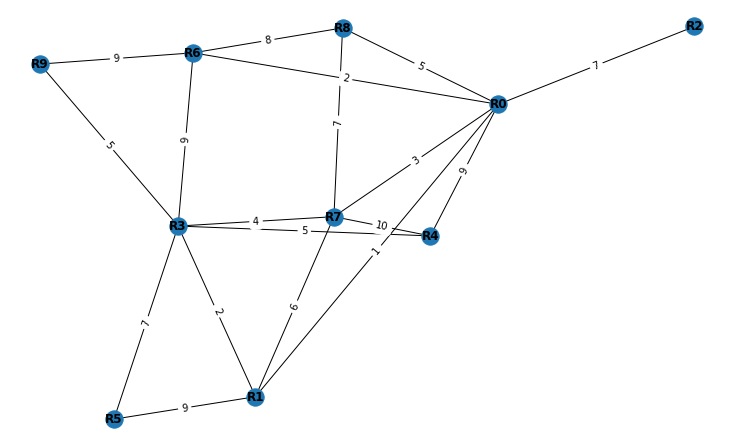

In [5]:
if visualize:
    plt.figure(3,figsize=(10,6)) 
      
    pos=nx.spring_layout(G)
    nx.draw(G, pos, with_labels = True, font_weight = 'bold')
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.show()

if display_tables:
    network.visualize()   

### Visualize LIB and LFIB tables

In [6]:
if topology_option in ["custom","random"]:
    router_list = ["R0"]
    
elif topology_option == "external":
    router_list = ["Houston"]    # change as appropiate!

network.visualize(router_list)

Number of forwarding rules in the Network:56
--------------------
R0.LIB
('R0', 'R6')(bypass_R0_R6): {'owner': <rsvpte.ProcRSVPTE object at 0x7fb2d8975fd0>, 'local_label': '16'}
('R0', 'R7')(bypass_R0_R7): {'owner': <rsvpte.ProcRSVPTE object at 0x7fb2d8975fd0>, 'local_label': '17'}
('R0', 'R8')(bypass_R0_R8): {'owner': <rsvpte.ProcRSVPTE object at 0x7fb2d8975fd0>, 'local_label': '18'}
('R0', 'R1', 'R3')(bypass_R0_R1_R3): {'owner': <rsvpte.ProcRSVPTE object at 0x7fb2d8975fd0>, 'local_label': '19'}
('R1', 'R3')(bypass_R1_R3): {'owner': <rsvpte.ProcRSVPTE object at 0x7fb2d8975fd0>, 'local_label': '20'}
('R1', 'R3', 'R9')(bypass_R1_R3_R9): {'owner': <rsvpte.ProcRSVPTE object at 0x7fb2d8975fd0>, 'local_label': '21'}
('R1', 'R0')(bypass_R1_R0): {'owner': <rsvpte.ProcRSVPTE object at 0x7fb2d8975fd0>, 'local_label': '22'}
('R3', 'R4')(bypass_R3_R4): {'owner': <rsvpte.ProcRSVPTE object at 0x7fb2d8975fd0>, 'local_label': '23'}
('R6', 'R0')(bypass_R6_R0): {'owner': <rsvpte.ProcRSVPTE object at 0x

### Inspect RSVP specific tables (if enabled)

In [7]:
r = router_list[0] # the first router from the previous cell

if enable_RSVP:
    #enable as desired to visualize different tables
    # tabl = network.routers[r].clients["RSVP-TE"].headended_lsps    # Tunnels starting at r
    # tabl = network.routers[r].clients["RSVP-TE"].requested_lsps    # Tunnels through r
    tabl = network.routers[r].clients["RSVP-TE"].requested_bypasses    # backup paths through r

    pprint(tabl)
    
if enable_services:
    tabl = network.routers[r].clients["service"].services
    pprint(tabl)


{('R0', 'R1', 'R3'): {'FEC': <mpls_fwd_gen.oFEC object at 0x7fb2d89930a0>,
                      'bypass_path': ['R0', 'R7', 'R3'],
                      'next_hop': 'R7'},
 ('R0', 'R6'): {'FEC': <mpls_fwd_gen.oFEC object at 0x7fb2d8987520>,
                'bypass_path': ['R0', 'R1', 'R3', 'R6'],
                'next_hop': 'R1'},
 ('R0', 'R7'): {'FEC': <mpls_fwd_gen.oFEC object at 0x7fb2d8993280>,
                'bypass_path': ['R0', 'R1', 'R7'],
                'next_hop': 'R1'},
 ('R0', 'R8'): {'FEC': <mpls_fwd_gen.oFEC object at 0x7fb2d8993f40>,
                'bypass_path': ['R0', 'R6', 'R8'],
                'next_hop': 'R6'},
 ('R1', 'R0'): {'FEC': <mpls_fwd_gen.oFEC object at 0x7fb2d89931c0>,
                'bypass_path': ['R1', 'R7', 'R0'],
                'next_hop': None},
 ('R1', 'R3'): {'FEC': <mpls_fwd_gen.oFEC object at 0x7fb2d8987e50>,
                'bypass_path': ['R1', 'R0', 'R7', 'R3'],
                'next_hop': 'R7'},
 ('R1', 'R3', 'R9'): {'FEC': <mpls_fwd_g

# Simulation

### Define failure scenario
In the next cell, specify the desired failure scenario by stating explicitly the set of failed links F.

In [8]:
# Failed Scenarios
F = []  # No failures

# other examples:
# F = [("R1","R3"),("R0","R6"),("R7","R3"),("R3","R4")]
# F = [("R3","R4"),("R0","R5")]
# F = [("R3","R8"),("R0","R6"),("R0","R8")]


##########################################################################################
# Compute the graph after removing the failed sets

def filter_node(n):
    #return False if n in L else True
    return True

def filter_edge(n1,n2):
    if (n1,n2) in F or (n2,n1) in F:
        return False
    return True

view = nx.subgraph_view(network.topology, filter_node = filter_node, filter_edge = filter_edge)


## Packet tracer / Simulator

In [9]:
# Simulate the forwarding of a single packet

# change as appropiate!
if topology_option == "custom":
    init_router = "R0"
    init_stack = ["50515"]

if topology_option == "random":
    init_router = "R0"
    init_stack = ["50515"]
    
elif topology_option == "external":
    init_router = "Houston"    
    init_stack = ["50518"]

# instantiate
p = MPLS_packet(network, restricted_topology = view, init_router = init_router, init_stack = init_stack, verbose = True)

# send
p.fwd()   # prints boolean forwarding result at the end.


Current router: R0
Current outmost label: 50515
 FORWARDING Complete: No available forwarding rules at router R0 for label 50515, yet MPLS stack is not empty


False

## Run packets simulations for all realistic flows

In [10]:
sim = Simulator(network, trace_mode="links",  restricted_topology = view)
sim.run()

running simulation with seed 0.7484350209183833
Computing flows for simulation.


### Visualize traceroutes for all simulations.

In [11]:
print("\n\nTraces:")
sim.print_traces()



Traces:
"True;0;R0;26;[('R0', 'R6'), ('R6', None)];"
"True;0;R0;27;[('R0', 'R7'), ('R7', None)];"
"True;0;R0;28;[('R0', 'R8'), ('R8', None)];"
"True;0;R1;24;[('R1', 'R3'), ('R3', 'R4'), ('R4', None)];"
("True;0;R2;16;[('R2', 'R0'), ('R0', 'R1'), ('R1', 'R3'), ('R3', 'R9'), ('R9', "
 'None)];')
"True;0;R3;24;[('R3', 'R9'), ('R9', None)];"
"True;0;R5;17;[('R5', 'R1'), ('R1', 'R0'), ('R0', None)];"
"True;0;R6;21;[('R6', 'R0'), ('R0', 'R1'), ('R1', 'R3'), ('R3', None)];"
"True;0;R6;22;[('R6', 'R0'), ('R0', 'R1'), ('R1', 'R3'), ('R3', None)];"
"True;0;R8;19;[('R8', 'R0'), ('R0', None)];"


### Print results

In [12]:
success_ratio, total_flows = sim.success_rate()
print(f"""Simulation run for {total_flows} flows on failure set {F}""")
print(f"The success percentage (number of successfully forwardes packet / number of simulations) is {success_ratio*100} %")

Simulation run for 10 flows on failure set []
The success percentage (number of successfully forwardes packet / number of simulations) is 100.0 %
